<a href="https://colab.research.google.com/github/FranciscoHernandez1998/Determinacion-de-la-salud-de-una-colmena-utilizando-CNN/blob/master/Determinaci%C3%B3n_de_la_salud_de_una_colmena_utilizando_Redes_Neurales_Convolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Librerías comunes necesarias
%tensorflow_version 1.x
import pandas as pd #Libreria para analisis y manipulacion de datos
import numpy as np #Libreria para computacion de arreglos multidimensionales
import sys #Modulo que Provee acceso a funciones y objetos mantenidos por el interprete
import os #Modulo que permite acceder a funcionalidades dependientes del O.S. como informacion del entorno y manipulacion de estructura del directorio
import random #Generador de numeros random
from pathlib import Path #Modulo que simplifica la forma de trabajar con folderes y archivos

TensorFlow 1.x selected.


In [0]:
#Herramientas para el procesamiento de imagenes
import imageio #Libreria de python para leer y escribir facilmente imagenes

#Librerias para el procesamiento de imagenes
import skimage 
import skimage.io
import skimage.transform

In [3]:
#Creacion de graficos
import matplotlib.pyplot as plt #Libreria para visualizacion de datos
import seaborn as sns #Libreria para visualizacion de datos basada en matplot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Machine Learning
import scipy #Libreria con herramientas y algoritmos matematicos
#Libreria de ayuda para deep learning
from sklearn.model_selection import train_test_split 
from sklearn import metrics, svm
from sklearn.metrics import confusion_matrix

In [5]:
#Modulos de la libreria keras para la construccion de modelos de deep learning
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback
from keras.utils import to_categorical
import tensorflow

Using TensorFlow backend.


In [6]:
np.random.seed(42)
tensorflow.random.set_random_seed(42)
plt.style.use('seaborn-white')
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [7]:
#Instalar libreria de Kaggle
!pip install -q kaggle

os.environ['KAGGLE_USERNAME'] = "franciscorivera"
os.environ['KAGGLE_KEY'] = "8b03ec789f5c72b7d495050d71c36fde"

#Dataset utilizado
!kaggle datasets download -d jenny18/honey-bee-annotated-images

 81% 41.0M/50.5M [00:01<00:00, 13.8MB/s]
100% 50.5M/50.5M [00:02<00:00, 26.2MB/s]


In [0]:
!unzip -o 'honey-bee-annotated-images.zip'

In [0]:
#Variables Globales

#Path hacia carpeta con imagenes
img_folder='bee_imgs/bee_imgs/'

#Dimensiones de las imagenes
img_width=100
img_height=100

#Canales de las imagenes (RGB)
img_channels=3

In [10]:
bees=pd.read_csv('bee_data.csv', dtype={'subspecies':'category', 'health':'category','caste':'category'})
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
if False in bees:
  print("Hay imagenes que no existen")
else:
  print("Todas las imagenes existen")
if bees.isnull().values.any():
  print("Hay valores nulos\n")
else:
  print("No hay valores nulos\n\n")
bees.head()

Todas las imagenes existen
No hay valores nulos




,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


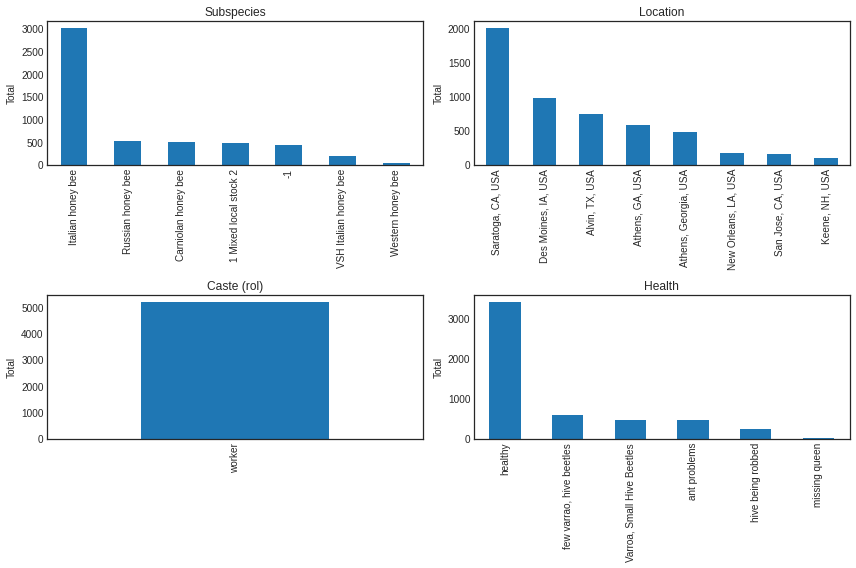

In [11]:
# Observar los datos

# Matrix de graficas tamaño 2x2 de imagenes width 12 y height 8
#Guarda figure, y subplots
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))


bees.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Total')
ax[0,0].set_title('Subspecies')


bees.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Total')

bees.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste (rol)')
ax[1,0].set_ylabel('Total')

bees.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Total')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

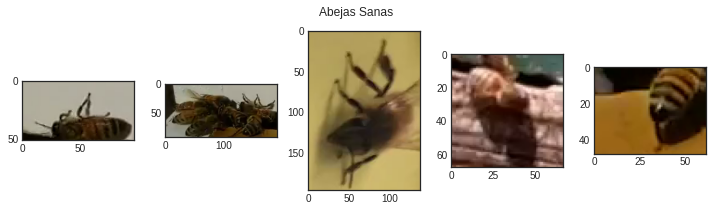

In [12]:
# Observar Abejas sanas
ncols = 5
healthy = bees[bees['health'] == 'healthy'].sample(ncols)


f, ax = plt.subplots(nrows=1,ncols=ncols, figsize=(10,3))

for i in range(0,5): 
    file = img_folder + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Abejas Sanas")
plt.tight_layout()
plt.show()


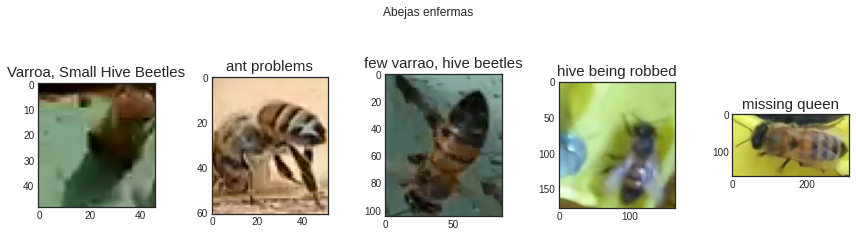

In [13]:
#Abejas enfermas

health_cats = bees['health'].cat.categories
f, ax = plt.subplots(1, health_cats.size-1, figsize=(12,4))
i=0
for c in health_cats:
    if c == 'healthy': 
      continue
    bee = bees[bees['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(img_folder + bee['file']))
    ax[i].set_title(bee['health'], fontsize=15)
    i += 1
    
plt.suptitle("Abejas enfermas")    
plt.tight_layout()
plt.show()

In [0]:
#Generacion de datasets
def split_balance(bees):
    #Dividir las imagenes en train, validation y test

    #Dividir el dataset en train y test
    #train_bees = 75% del dataset
    #test_bees = 25% del dataset
    train_bees, test_bees = train_test_split(bees, random_state=24)


    # Dividir train en dos datasets, uno de train y otro de validacion
    # para testing se utiliza val_bees (validation test) con 10% de la data de train_bees
    # train bees se conforma entonces del 90% de la data que tenia antes
    train_bees, val_bees = train_test_split(train_bees, test_size=0.1, random_state=24)


    
    # Numero de samples en cada categoria
    # este sera, la cantidad de imagenes actuales en train_bees dividida la cantidad de clases (6), osea, posible estado de salud de la abeja
    num_samples = int(len(train_bees)/6)


    #Agrupar por health para balancear segun este campo
    train_bees = train_bees.groupby('health', as_index=False)

    #Aplicar la siguiente funcion a los ejes del dataframe, para reducir el dataset a un tamaño fijo y que este balanceado
    #Si los datos son insuficientes, se aceptan duplicados
    #train_bees sera el dataset balanceado por el campo Health
    train_bees = train_bees.apply(lambda g:  g.sample(num_samples, replace=True))


    #se retornan tres datasets: train bees, validation bees, test bees
    return(train_bees, val_bees, test_bees)

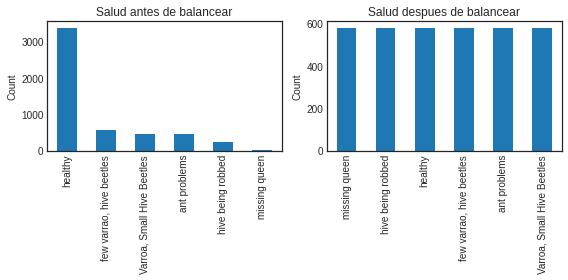

In [15]:
def plot_balanced(train_bees, train_bees_bal):
  #train_bees: Antes de balancear
  #train_bees_bal: Despues de balancear

    # Graficar antes y despues de balancear
    f, axs = plt.subplots(1,2, figsize=(8,4))

    # Antes
    ax = train_bees['health'].value_counts().plot(kind='bar', ax=axs[0])
    ax.set_title('Salud antes de balancear')
    ax.set_ylabel('Count')

    # Despues
    ax = train_bees_bal['health'].value_counts().plot(kind='bar', ax=axs[1])
    ax.set_title('Salud despues de balancear')
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Split/balance y grafica del resultado
train_bees_bal, val_bees, test_bees = split_balance(bees)
plot_balanced(bees, train_bees_bal)

# Utilizar el dataset balanceado a partir de ahora
train_bees = train_bees_bal

In [0]:
#Leer, escalar, y ajustar canales de las imagenes
def read_img(file):
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

def prepare2train(train_bees, val_bees, test_bees):
    #Conversion de todas las imagenes a los mismos parametros como width, height y channels
    #np.stack proporciona un NumPy array, el cual es el input de la CNN
    
    ##pd.get_dummies nos proporciona el array con uan conversion de la columna health de una 
    ##variable categorica a una variable indicadora, es aqui donde obtenemos el array con one 
    ##hot encoding para cada una de las enfermedades

    #Imagenes de entrenamiento
    train_X = np.stack(train_bees['file'].apply(read_img))
    train_y  = pd.get_dummies(train_bees['health'], drop_first=False)

    #Imagenes de validacion para calcular el val_loss
    val_X = np.stack(val_bees['file'].apply(read_img))
    val_y = pd.get_dummies(val_bees['health'], drop_first=False)

    #Imagenes de Prueba
    test_X = np.stack(test_bees['file'].apply(read_img))
    test_y = pd.get_dummies(test_bees['health'], drop_first=False)

    #Data Augmentation para el modelo 
    generator = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False,
            rotation_range=180,  # Rotacion random de la imagen en un rango 0 a 180 grados
            zoom_range = 0.1, #Zoom random de la imagen  
            width_shift_range=0.2,  #Cambio random del width de una imagen 
            height_shift_range=0.2,  #Cambio random del height de una imagen
            horizontal_flip=True,  #Rotacion horizontal o vertical de las imagenes
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

In [0]:
#Se ejecuta la preparacion de la imagenes en sus respectivos arreglos
#y se obtienen los arreglos con one hot encoding de las enfermedades
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees)

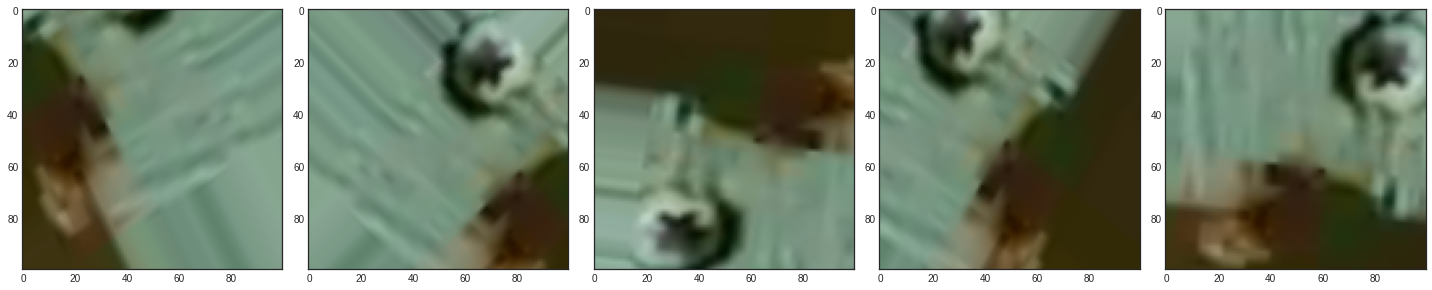

In [18]:
#Observar que funcione bien el generador de data aumentada
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
data_gen = generator.flow( train_X,train_y, batch_size=5 )

augmented_images = [data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [19]:
#Se va almacenar el modelo con el mejor valor de accuracy que resulte durante el entrenamiento
#Se almacenaran solamente lo pesos del modelo
checkpointer = ModelCheckpoint('best_model.h5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)

# Build CNN model
#Se construye el modelo de la red convolucional
model=Sequential()
model.add(Conv2D(5, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model.add(MaxPool2D(2))
model.add(Conv2D(10, kernel_size=3, activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
#Se entrena el modelo con la data de train y se validan los resultados con la data de validation
training = model.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[checkpointer])

#Se cargan en el modelo los mejores pesos del mejor modelo obtenido durante el entrenamiento
model.load_weights('best_model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/20
50/50 [==============================] - 22s 448ms/step - loss: 1.5404 - accuracy: 0.3673 - val_loss: 1.2237 - val_accuracy: 0.6160

Epoch 00001: val_accuracy improved from -inf to 0.61598, saving model to best_model.h5
Epoch 2/20
50/50 [==============================] - 19s 372ms/step - loss: 0.9797 - accuracy: 0.5971 - val_loss: 0.9559 - val_accuracy: 0.6546

Epoch 00002: val_accuracy improved from 0.61598 to 0.65464, saving model to best_model.h5
Epoch 3/20
50/50 [==============================] - 18s 367ms/step - loss: 0.7544 - accuracy: 0.6701 - val_loss: 0.7536 - val_accuracy: 0.7345

Epoch 00003: val_accuracy improved from 0.65464 to 0.73454, saving model to best_model.h5
Epoch 4/20
50/50 [==============================] - 18s 369ms/step - loss: 0.6610 - accuracy: 0.6948 - val_loss: 0.7319 - val_accuracy: 0.7139

Epoch 00004: val_accuracy did not improve from 0.73454
Epoch 5/20
50/50 [=

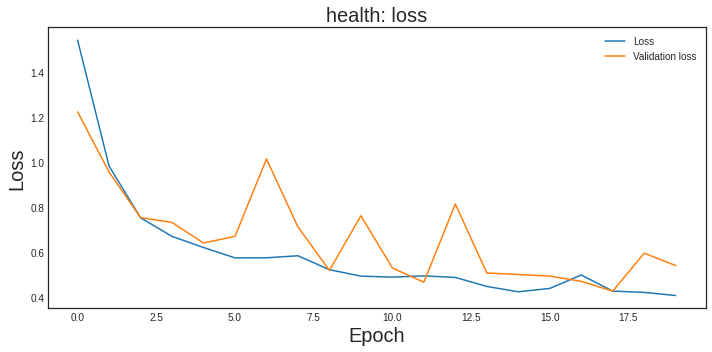

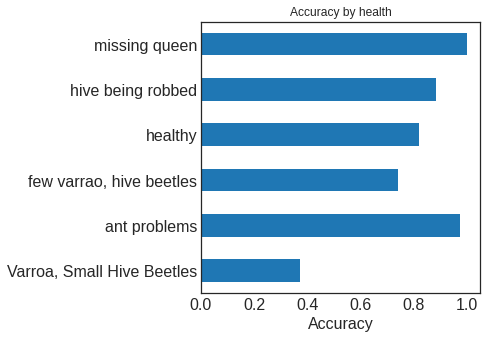

In [20]:
#Analisis del modelo entrenado y evaluacion
f, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(training.history['loss'], label="Loss")
ax.plot(training.history['val_loss'], label="Validation loss")
ax.set_title('%s: loss' % 'health',size=20)
ax.set_xlabel('Epoch',size=20)
ax.set_ylabel('Loss',size=20)
ax.legend()

#Accuracy
plt.tight_layout()
plt.show()



print('\n\n')

#Se realiza la prediccion utilizando el modelo resultante con los datos de prueba
test_pred = model.predict(test_X)

#Accuracy segun estados de salud
acc_by_health = np.logical_and((test_pred > 0.5), test_y).sum()/test_y.sum()
acc_by_health.plot(kind='barh', title='Accuracy by %s' % 'health',fontsize=16,figsize=(5,5))
plt.xlabel('Accuracy',size=16)
plt.show()

In [21]:

test_pred = np.argmax(test_pred, axis=1)
test_truth = np.argmax(test_y.values, axis=1)

#Valores de la funcion Loss, y Accuracy obtenidos
test_res = model.evaluate(test_X, test_y.values, verbose=0)
print('Loss function: ', round(test_res[0], 2))
print('Accuracy: ', round(test_res[1], 2))

Loss function:  0.42
Accuracy:  0.82


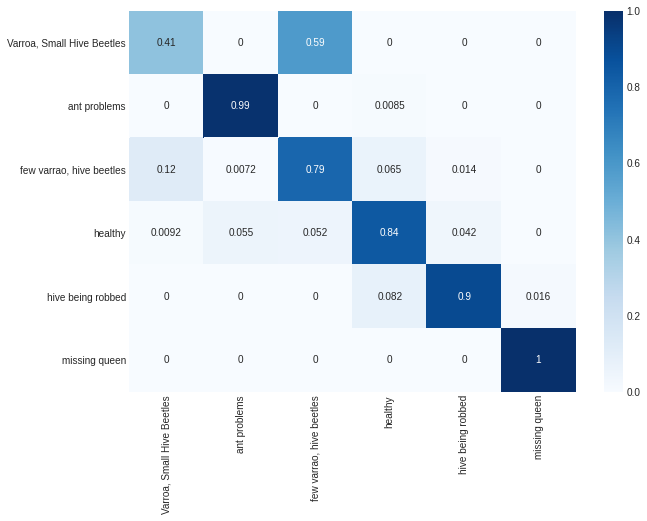

In [22]:
#Matriz de confusion, grafica como mapa de calor

dataframe_matriz_confusion = pd.DataFrame(confusion_matrix(test_truth, test_pred, normalize='true'), index = [i for i in test_y.columns],
                  columns = [i for i in test_y.columns])
plt.figure(figsize = (10,7))
sns.heatmap(dataframe_matriz_confusion, annot=True, cmap=plt.cm.Blues)

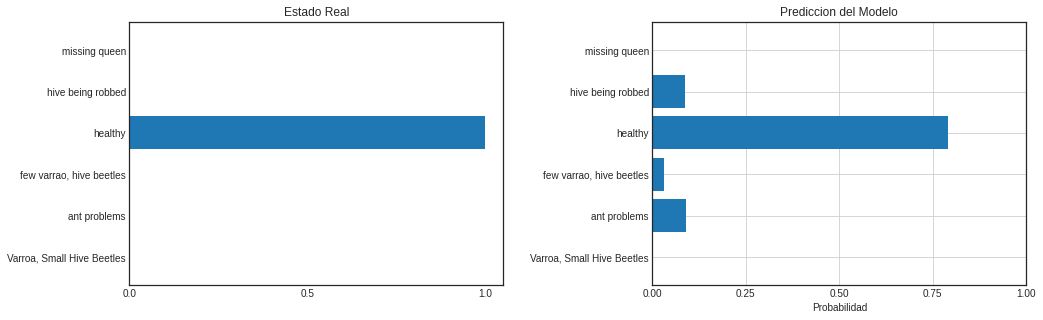

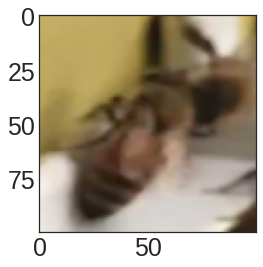

In [23]:
#Mostrar predicciones sobre una imagen especifica
idx = random.randint(0,len(test_X)-1)
img = test_X[idx,:,:,:]
real_Value = test_y.iloc[idx]

img_test = np.reshape(img,(1,img.shape[0], img.shape[1], img.shape[2]))

predictions = model.predict(img_test)

arr_Predictions = []

for i in range(0,6):
  arr_Predictions.append(predictions[0,i])
  
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].barh(test_y.columns, real_Value)
ax[0].set_title('Estado Real')

ax[1].set_title('Prediccion del Modelo')
ax[1].set_xlim(0,1)
ax[1].grid(True)
ax[1].barh(test_y.columns, arr_Predictions)
ax[1].set_xlabel('Probabilidad')
plt.rcParams.update({'font.size': 25})

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

print('\n\n')
plt.imshow(img, cmap=plt.cm.binary)
plt.show()